<a href="https://colab.research.google.com/github/bokutachi256/gisday2021/blob/main/4_%E9%81%BF%E9%9B%A3%E8%80%85%E3%82%A8%E3%83%BC%E3%82%B8%E3%82%A7%E3%83%B3%E3%83%88%E3%81%AE%E8%A1%8C%E5%8B%95%E3%83%AB%E3%83%BC%E3%83%AB%E3%82%92%E5%A4%89%E6%9B%B4%E3%81%99%E3%82%8B%5BGISDAY2021%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Pythonで作るマルチエージェントシミュレーション
* 東京都立大学 都市環境学部 地理環境学科 中山大地
* 2021年12月4日 東京都立大学 南大沢キャンパス（オンライン開催）
* このテキストのURL [https://github.com/bokutachi256/gisday2021](https://github.com/bokutachi256/gisday2021)
* Google ColaboratoryのURL [https://colab.research.google.com/](https://colab.research.google.com/)
* MESAのURL [https://mesa.readthedocs.io/](https://mesa.readthedocs.io/)

# この章でやること

この章では避難者エージェントのルールを変更します．
具体的にはゴールに近づいた避難者エージェントはなるべくゴールに近づくように行動します．

そのためにはゴールをエージェントとして定義し，
避難者エージェントは周囲を検索してゴールエージェントが見つかった場合には
ゴールになるべく近づく方向に移動します．
これはエージェントの移動の指針となる評価関数にゴールまでの距離を用い，
評価関数を最小化する方向に移動することで実装します．

# Mesaのインストール

In [ ]:
%pip install mesa

# 必要ライブラリのインポート

In [ ]:
%matplotlib notebook

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# ここまでのモデル

## スペースのモデル



前の章で作成したスペース及び避難者エージェントは以下のようになっていました．

* スペースはMultiGridを使う
* ~~エージェントの初期位置はランダムに決定する~~
* エージェントの初期位置は`start_x`と`start_y`とする
* ゴールは`goal_x`と`goal_y`とする
* ~~エージェントは上下左右にランダムに動く~~
* エージェントは上下左右のうち，他の避難者エージェントがいないセルにランダムに動く
* 壁エージェントを生成し，避難者エージェントは壁の上に移動しない
* データコレクターには以下の情報を格納する
 * model_reporter：ゴールした人数の累計，Stepごとのゴールした人数
 * agent_reporter：エージェントの座標とゴールしたかどうかの状態を保持

実行してみましょう．


In [ ]:
class EvacModel(Model):

  # コンストラクタにwall（壁の位置を示すndarray）を追加した
  def __init__(self, N, width, height, start_x, start_y, goal_x, goal_y, wall):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus=False)

    # 壁の座標を保持するプロパティの定義
    self.wall_x = list()
    self.wall_y = list()
    
    # 壁の定義をプロパティとして保持する
    self.wall = wall
    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # EvacAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントを配置する
      self.grid.place_agent(a, (start_x, start_y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})

    # 避難者エージェント配置直後（初期状態）の状況をデータコレクターで取得  
    self.datacollector.collect(self)
  
    # 壁エージェントを配置する
    # 壁の配列から座標を取得する．壁の配列は上下反転させる
    wall_y = np.where(np.flipud(self.wall) >0)[0]
    wall_x = np.where(np.flipud(self.wall) >0)[1]
    # 取得した壁の座標に壁エージェントを配置する
    for i in range(len(wall_x)):
      a = WallAgent(i, self)
      self.grid.place_agent(a, (wall_x[i], wall_y[i]))
      # 壁の座標を保持する
      self.wall_x.append(wall_x[i])
      self.wall_y.append(wall_y[i])
      
  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)

## ゴール人数の累計を求める関数

これも実行します．

In [ ]:

# そのステップでゴールした人数を求める関数
def goal_pop(model):
  return(model.evac_comp)

# ゴールした人数の累計を求める関数
def compute_goal(model):
  agent_goal = sum([agent.mygoal for agent in model.schedule.agents])
  return (agent_goal)


## 避難者エージェントのモデル

実行します．

In [ ]:
class EvacAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0
    self.wealth = 0

  # エージェントの移動
  def move(self):
    possible_steps = self.model.grid.get_neighborhood(
      self.pos,
      moore = False,
      include_center = False)

    # 周囲に移動可能なセルがあるか検索する
    possible_steps2 = [a for a in possible_steps if len(self.model.grid.get_cell_list_contents(a)) < 1]

    if len(possible_steps2) > 0:
      new_position = self.random.choice(possible_steps2)
    else:
      new_position = self.pos
    self.model.grid.move_agent(self, new_position)
  
  # ゴールに到達したか判定する関数
  def if_goal(self):
    if self.pos == self.model.goal:
      self.mygoal += 1
      self.model.evac_comp += 1
      # ゴールしたらエージェントを削除する
      self.model.grid.remove_agent(self)

  def step(self):
    if self.mygoal == 0:
      self.move()
      self.if_goal()


## 壁エージェントの定義

実行します．

In [ ]:
# 壁エージェントの定義
class WallAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)


## モデルの実行部

とりあえず100ステップ実行します．

In [ ]:
# モデルを実行する
start_x = 4
start_y = 4
goal_x = 0
goal_y = 0

# 壁の定義（1: 壁，0: 通路）
wall = np.array(
    [[1,0,0,0,0],
     [0,0,1,0,0],
     [0,1,1,0,1],
     [0,0,0,0,0],
     [0,1,0,0,0]])

# モデルの生成，引数として壁の定義を加える
model = EvacModel(10, 5, 5, start_x, start_y, goal_x, goal_y, wall)

# 100ステップ実行する
for i in range(100):
  model.step()

# 避難者エージェントの新しい行動ルール

今までの避難者エージェントは，自分の上下左右のセルのうち他のエージェント（避難者エージェント及び壁エージェント）がいないセルをランダムに選択して移動先としていました．
ここでは，避難者エージェントの行動ルールを以下のように改良します．

1. 避難者エージェントは上下左右のセルのうち，エージェントがいないセルにランダムで移動する．
1. ゴールに近づいたらなるべくゴールの方向に移動する．

最初のルールについては今までと同じです．

2番目のルールについては，ゴールをエージェントとして実装することにより
周囲のエージェントを検索するメソッド`grid.get_neighbors`でゴールの検索が可能になります．
検索範囲にゴールがあった場合には，自分の位置からゴールまでの距離を計算し，
上下左右の移動可能なセルのうちゴールまでの距離が短くなるセルを移動候補にします．

具体的なアルゴリズムは以下のようになります．

1. ゴール地点を表すゴールエージェントを作成する．
1. ゴールエージェントをスペースに配置する．
1. 避難者エージェントの周囲2セル以内のエージェント（他の避難者エージェント，壁エージェント，ゴールエージェント）を検索し，ゴールがあるか判断する．
1. 避難者エージェントの上下左右のセルのうち，移動可能なセルを検索する
1. 移動可能なセルからゴールエージェントまでの距離を求める
1. 移動候補のセルからゴールまでの距離が短くなるセルを絞り込む．
1. 移動候補セルの中から移動方向をランダムに選択する
 

# 避難者エージェントへの行動ルールの追加

## ゴールエージェントの作成

ゴールエージェントもクラス`Agent`を継承して作成します．
ゴールエージェントは移動する必要はないのでコンストラクタのみです．
ただし，作成したエージェントの種類を表すプロパティ`category`を追加し，
値を`goal`とします．


In [ ]:
# ゴールエージェントの定義
class GoalAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    # エージェントの種類を示すプロパティを追加
    self.category = 'goal'


## 壁エージェントへのプロパティ追加

壁エージェントにもプロパティ`category`を追加し，値を`wall`とします．



In [ ]:
# 壁エージェントの定義
class WallAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.category = 'wall'


## 避難者エージェントへのプロパティ追加

避難者エージェントのコンストラクタにもプロパティ`category`を加え，値を`evacagent`にします．


In [ ]:
class EvacAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0
    self.wealth = 0
    self.category = 'evacagent'

  # エージェントの移動
  def move(self):
    possible_steps = self.model.grid.get_neighborhood(
      self.pos,
      moore = False,
      include_center = False)

    # 周囲に移動可能なセルがあるか検索する
    possible_steps2 = [a for a in possible_steps if len(self.model.grid.get_cell_list_contents(a)) < 1]

    if len(possible_steps2) > 0:
      new_position = self.random.choice(possible_steps2)
    else:
      new_position = self.pos
    self.model.grid.move_agent(self, new_position)
  
  # ゴールに到達したか判定する関数
  def if_goal(self):
    if self.pos == self.model.goal:
      self.mygoal += 1
      self.model.evac_comp += 1
      # ゴールしたらエージェントを削除する
      self.model.grid.remove_agent(self)

  def step(self):
    if self.mygoal == 0:
      self.move()
      self.if_goal()


## スペースにゴールエージェント生成を追加する

以下のようにスペースにゴールエージェント生成を加えます．

```python
    a = GoalAgent(1, self)
    self.grid.place_agent(a, (goal_x, goal_y))
```

ゴールエージェント生成を加えたスペースの定義は以下のようになります．

In [ ]:
class EvacModel(Model):

  # コンストラクタにwall（壁の位置を示すndarray）を追加した
  def __init__(self, N, width, height, start_x, start_y, goal_x, goal_y, wall):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus=False)

    # 壁の座標を保持するプロパティの定義
    self.wall_x = list()
    self.wall_y = list()
    
    # 壁の定義をプロパティとして保持する
    self.wall = wall
    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # EvacAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントを配置する
      self.grid.place_agent(a, (start_x, start_y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})

    # 避難者エージェント配置直後（初期状態）の状況をデータコレクターで取得  
    self.datacollector.collect(self)
  
    # 壁エージェントを配置する
    # 壁の配列から座標を取得する．壁の配列は上下反転させる
    wall_y = np.where(np.flipud(self.wall) >0)[0]
    wall_x = np.where(np.flipud(self.wall) >0)[1]
    # 取得した壁の座標に壁エージェントを配置する
    for i in range(len(wall_x)):
      a = WallAgent(i, self)
      self.grid.place_agent(a, (wall_x[i], wall_y[i]))
      # 壁の座標を保持する
      self.wall_x.append(wall_x[i])
      self.wall_y.append(wall_y[i])
    
    # ゴールエージェントの配置
    a = GoalAgent(1, self)
    self.grid.place_agent(a, (goal_x, goal_y))

  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)

## モデルの実行

とりあえず30ステップ実行して途中経過を検討します．

In [ ]:
# モデルを実行する
start_x = 4
start_y = 4
goal_x = 0
goal_y = 0

# 壁の定義（1: 壁，0: 通路）
wall = np.array(
    [[1,0,0,0,0],
     [0,0,1,0,0],
     [0,1,1,0,1],
     [0,0,0,0,0],
     [0,1,0,0,0]])

# モデルの生成，引数として壁の定義を加える
model = EvacModel(10, 5, 5, start_x, start_y, goal_x, goal_y, wall)

# 30ステップ実行する
for i in range(30):
  model.step()

## 30ステップ終了時の状態をプロットする

確認のため30ステップ終了時の状況をプロットします．
これは前章で改良したアニメーション表示部の内容と同じです．

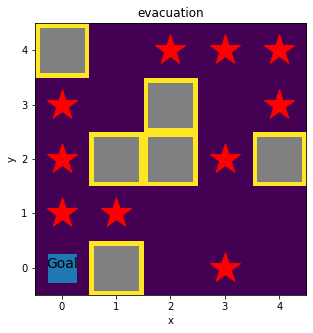

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
ax.text(goal_x, goal_y, 'Goal', size=14, ha='center')
ax.scatter(goal_x, goal_y, s=800, marker="s")

# imshowを使って壁配列を描画する．原点の移動と配列の上下反転を行う．
ax.imshow(np.flipud(wall), origin='lower')

# 壁をプロット
ax.scatter(model.wall_x, model.wall_y, c='gray', s=2000, marker="s")

agent_loc = model.datacollector.get_agent_vars_dataframe().xs(30, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
ax.scatter(x, y, s=1000, c="red", marker="*")

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

## 30ステップ終了時の避難エージェントの位置を表示する

エージェントのデータコレクターから30ステップ終了時の避難者エージェントの座標を取得して表示します．

In [ ]:
model.datacollector.get_agent_vars_dataframe().xs(30, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)

AgentID
0    (0, 2)
1    (4, 4)
2    (2, 4)
3    (3, 4)
4    (3, 2)
5    (1, 1)
6    (3, 0)
7    (4, 3)
8    (0, 1)
9    (0, 3)
Name: Pos, dtype: object

## 任意のエージェントから一定範囲にあるエージェントを検索する



まず任意の避難者エージェントの座標を取得し，`selfpos`に格納します．
取得した避難者エージェントの座標からゴール近くにいる避難者エージェントの座標を取得します．

```python
selfpos = model.datacollector.get_agent_vars_dataframe().xs(30, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)[ゴール近くの避難者エージェントの番号]
```

`model.grid.get_neighbors`を使って対象とした避難者エージェントから一定範囲のエージェントを検索します．
ここではゴール近くの避難者エージェントの半径２メッシュ以内のエージェントを検索します．

```python
neighbor_agents = model.grid.get_neighbors(selfpos, moore=True, radius=2, include_center=False)
```

`model.grid.get_neighbors`の引数ですが，`moor`は8方向検索(`True`）か4方向検索（`False`）か，`radius`は検索の範囲（グリッド）になります．
この例では対象としている避難者エージェントの周囲5×５メッシュ（８方向で半径２メッシュ）にあるエージェントを検索します．
戻り値は見つかったエージェントのリストになるので，`neighbor_agents`に格納します．

以下で実際に実行してみましょう．
1行目最後の`[]`に対象となる避難者エージェントの番号を入れるのを忘れないようにしてください．

In [ ]:
selfpos = model.datacollector.get_agent_vars_dataframe().xs(30, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)[1]
neighbor_agents = model.grid.get_neighbors(selfpos, moore=True, radius=2, include_center=False)
neighbor_agents

検索結果が表示されましたが，内容は見つかったエージェントのポインタになっているためこのままでは使い道がありません．
ただ，エージェントのクラス名が表示されているので，ゴールがあるかどうかはわかります．

次で検索結果にゴールが含まれているかどうか判別します．

## 検索範囲にゴールエージェントがあるか判別する

すべてのエージェント（避難者エージェント，壁エージェント，ゴールエージェント）にはエージェントの種別を表すプロパティ`category`があります．
見つかったエージェントうちどれかのプロパティ`category`が`goal`だった場合，検索結果にゴールが含まれていることになります．

まずは内包表記を使って見つかったエージェントのプロパティ`category`のリストを作成します．

```python
[a.category for a in neighbor_agents]
```

次に`in`演算子を使ってリストの中に`goal`の文字があるか検索します．
`goal`があった場合は戻り値が`True`になり，なかった場合は`False`になります．

```python
'goal' in [a.category for a in neighbor_agents]
```

以下を実行してみます．
ここではゴールが含まれていたかどうかの状態を`isgoal`に代入しています．

In [ ]:
isgoal = 'goal' in [a.category for a in neighbor_agents]
print(isgoal)

True


## 自分とゴールの距離を求める

ゴールが含まれていた場合はなるべくゴールに近づく方向に移動します．
そのためには自分とゴールの座標から距離を求めなくてはなりません．

自分の座標は避難者エージェントのプロパティ`selfpos`に格納されているのでそのまま使います．
これに対しゴールの座標は以下のように求めます．

```python
neighbor_agents = model.grid.get_neighbors(selfpos, moore=True, radius=2, include_center=False)
goalpos = [a.pos for a in neighbor_agents if a.category=='goal']
```

まず`model.grid.get_neighbors`で自分の周囲２メッシュのエージェントを検索し，見つかったエージェントのリストを`neighbor_agent`に格納します．
次に内包表記を使って`neighbor_agent`にあるエージェントのうち，`category`が`'goal'`であるエージェントのプロパテイ`pos`を取得します．
プロパティ`pos`はエージェントの座標なので，ゴールの座標が取得できます．
これを`goalpos`に格納します．



In [ ]:
neighbor_agents = model.grid.get_neighbors(selfpos, moore=True, radius=2, include_center=False)
goalpos = [a.pos for a in neighbor_agents if a.category=='goal']
print(goalpos)
print(selfpos)

[(0, 0)]
(0, 1)


三平方の定理を使って自分の座標からゴールまでの距離を求めます．
ここではゴールと自分の座標をnp.arrayに変換することにより行列化して距離を計算しています．
```python
np.sqrt(np.sum(np.square(np.array(goalpos)-np.array(selfpos))))
```
実際には距離を求める関数にして一般化します．
一般化して関数にすると以下のようになります．
```python
def calc_dist(loc1, loc2):
  return np.sqrt(np.sum(np.square(np.array(loc1)-np.array(loc2))))
```

以下を実行してみましょう．
自分からゴールまでの距離を`self_goal_dis`に格納します．


In [ ]:
def calc_dist(loc1, loc2):
  return np.sqrt(np.sum(np.square(np.array(loc1)-np.array(loc2))))

self_goal_dis = calc_dist(goalpos, selfpos)
self_goal_dis

1.0

## 移動候補の絞り込み


それでは実際に移動方向を決めていきます．
まずは自分の周囲のセル（4方向）にあるセルを検索します．
これは今までと同様です．

この結果を`possible_step`に代入します．
これが第一次の移動候補になり，ここから移動候補を絞り込んでいきます．


In [ ]:
possible_steps = model.grid.get_neighborhood(selfpos, moore=False, include_center=False)
possible_steps

[(0, 0), (0, 2), (1, 1)]

`possible_step`の中からエージェントがいないセルを検索し，`possible_step2`に代入します．
これも今まで同じで第二次の移動候補になります．

In [ ]:
possible_steps2 = [a for a in possible_steps if len(model.grid.get_cell_list_contents(a)) < 1]
possible_steps2

[]

しかし，この章ではゴールもエージェントとして実装したため，
ゴールもエージェントがいるセルとして認識されてしまいます．

つまり`possible_step2`からゴールは削除される事になります．
これでは避難エージェントがゴールすることはできません．
これを解決するため，周囲のセルにゴールがあった場合はゴールを移動可能なセルに追加します．

例えば`model.grid.get_neighbors`を使って上下左右のセルを検索し，
ゴールエージェントの位置を示すプロパティ`pos`を`possible_steps2`に追加します．

これはこのように書く事ができます．

```python
ppp = model.grid.get_neighbors(selfpos, moore=False, include_center=False)
possible_steps2.extend([a.pos for a in ppp if a.category=='goal'])
```

中間変数を使わずに書くと以下のようになります．

```python
possible_steps2.extend([a.pos for a in model.grid.get_neighbors(selfpos, moore=False, include_center=False) if a.category=='goal'])
```

実行します．

In [ ]:
possible_steps2.extend([a.pos for a in model.grid.get_neighbors(selfpos, moore=False, include_center=False) if a.category=='goal'])
possible_steps2

[(0, 0)]

これでゴールが移動候補に加わりました．

### 移動候補のセルからゴールまでの距離を求める





移動候補`possible_steps2`に格納されている座標からゴールまでの距離を求めます．
これは先ほど作成したゴールまでの距離を求める関数`calc_dist`を内包表記内で使って求めます．
計算結果は`distances`に格納します．

以下を実行しましょう．

In [ ]:
distances = [calc_dist(goalpos, a) for a in possible_steps2]
distances

[0.0]

### 自分の現在位置よりゴールに近くなる移動候補のみを取り出す

`possible_steps2`からゴールに近くなる移動候補のみを取り出します．
基本的には`distances`内の距離のうち，自分からゴールまでの距離`self_goal_dis`より小さい要素のみを
`possible_steps2`から取り出します．

これも内包表記を使います．
```python
possible_steps3 = [a for a, b in zip(possible_steps2, distances) if b < self_goal_dis]
```
少々複雑な内包表記になっています．
まず`zip`を使って`possible_steps2`と`distances`をまとめて扱います．
`possible_steps2`と`distances`の要素は一対一で対応しています．
内包表記内では`possible_steps2`と`distances`の要素は`for a, b`によりそれぞれ`a`と`b`で表します．
ここで`if`を使い，`b`すなわち`distances`に格納されている移動候補からゴールまでの距離のうち,
自分からゴールまでの距離である`self_goal_dis`よりも距離が近い要素を`a`として`possible_steps2`から取得します．

この結果を`possible_steps3`に格納することにより，ゴールに近づく最終移動候補の座標のみを絞り込むことができます．


以下を実行しましょう．

In [ ]:
possible_steps3 = [a for a, b in zip(possible_steps2, distances) if b < self_goal_dis]
possible_steps3

[(0, 0)]

これで`possibble_steps3`が最終的な移動候補になりました．

実際にはゴールまでの移動距離が短くなる移動方向が存在しない場合があります．
そのときには以前のパターンのようにランダムに移動します．

ここまでをまとめると以下になります．

```python
  # エージェントの移動
  def move(self):

    # 自分の周囲のセル（4方向）にあるセルを検索する．
    possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    # その中で移動可能（エージェントがいない（エージェントの数が1未満））なセルを検索する
    possible_steps2 = [a for a in possible_steps if len(self.model.grid.get_cell_list_contents(a)) < 1]
    # 周囲4方向のセルにゴールが含まれている場合は移動可能なセルにゴールのセルを加える．
    possible_steps2.extend([a.pos for a in self.model.grid.get_neighbors(self.pos, moore=False, include_center=False) if a.category=='goal'])
    possible_steps3 = []

    # 自分を中心とする検索範囲（プラスマイナス2メッシュ内）のエージェントを検索する
    neighbor_agents = self.model.grid.get_neighbors(self.pos, moore=True, radius=2, include_center=False)
    # 検索範囲にゴールがあるかどうか判定する
    if 'goal' in [a.category for a in neighbor_agents]: # ゴールがあった場合
      # ゴールの座標を取得する
      goalpos = [a.pos for a in neighbor_agents if a.category=='goal']
      # 自分とゴールの距離を求める 
      self_goal_dis = calc_dist(goalpos, self.pos)
      # エージェントがいないセルからゴールまでの距離を求める
      distances = [calc_dist(goalpos, a) for a in possible_steps2]
      # 自分の現在位置よりゴールに近くなる移動候補のみを取り出す
      possible_steps3 = [a for a, b in zip(possible_steps2, distances) if b < self_goal_dis]
```


## 移動方向の決定

最終的な移動候補から移動方向を決定します．
しかし実際にはゴールに近づく移動候補がなかったりそもそも検索範囲内にゴールがない場合もあるため
移動方向の決定は思ったよりも複雑になります．

例えば以下のように書けるのですが，もっとスマートな方法があるかもしれません．

```python
    if len(possible_steps3) > 0: # ゴールに近づくセルに移動
      new_position = self.random.choice(possible_steps3)
    elif len(possible_steps2) > 0: # エージェントのいないセルに移動
      new_position = self.random.choice(possible_steps2)      
    else: # 動ける場所がない場合は移動しない
      new_position = self.pos
```



まずは以下の部分です．

```python
    if len(possible_steps3) > 0: # ゴールに近づくセルに移動
      new_position = self.random.choice(possible_steps3)
```

`possible_steps3`に移動候補がある，つまりゴールに近づく移動方向がある場合は
`possible_steps3`に要素が含まれていることになり，`possible_steps3`のサイズが0より大きくなります．
この場合は`possible_steps`からランダムに移動先を選びます．

次の`elif`ブロックです．

```python
    elif len(possible_steps2) > 0: # エージェントのいないセルに移動
      new_position = self.random.choice(possible_steps2) 
```

このブロックは`possible_steps3`に移動候補がない場合に`possible_steps2`に移動候補があるか評価します．
この条件が成り立つのはゴールは見つかっているがゴールに近づく移動候補がないか，
ゴールは見つかっていないが他のエージェントがいないセルがある場合です．
これらの場合は`possible_steps2`から移動先を選びます．

最後は`else`ブロックです．

```python
    else: # 動ける場所がない場合は移動しない
      new_position = self.pos
```

この条件が成り立つのは移動できるセルが周囲にない場合です．
この場合は避難者エージェントは移動しません．

移動方向が決まったら（もしくは移動しないことが決まったら），
`move_agent`を使って避難者エージェントを動かします．

```python
    self.model.grid.move_agent(self, new_position)
```

以上の新しい行動ルールをまとめると以下になります．

```python
  # エージェントの移動
  def move(self):

    # 自分の周囲のセル（4方向）にあるセルを検索する．
    possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    # その中で移動可能（エージェントがいない（エージェントの数が1未満））なセルを検索する
    possible_steps2 = [a for a in possible_steps if len(self.model.grid.get_cell_list_contents(a)) < 1]
    # 周囲4方向のセルにゴールが含まれている場合は移動可能なセルにゴールのセルを加える．
    possible_steps2.extend([a.pos for a in self.model.grid.get_neighbors(self.pos, moore=False, include_center=False) if a.category=='goal'])
    possible_steps3 = []

    # 自分を中心とする検索範囲（プラスマイナス2メッシュ内）のエージェントを検索する
    neighbor_agents = self.model.grid.get_neighbors(self.pos, moore=True, radius=2, include_center=False)
    # 検索範囲にゴールがあるかどうか判定する
    if 'goal' in [a.category for a in neighbor_agents]: # ゴールがあった場合
      # ゴールの座標を取得する
      goalpos = [a.pos for a in neighbor_agents if a.category=='goal']
      # 自分とゴールの距離を求める 
      self_goal_dis = calc_dist(goalpos, self.pos)
      # エージェントがいないセルからゴールまでの距離を求める
      distances = [calc_dist(goalpos, a) for a in possible_steps2]
      # 自分の現在位置よりゴールに近くなる移動候補のみを取り出す
      possible_steps3 = [a for a, b in zip(possible_steps2, distances) if b < self_goal_dis]

    if len(possible_steps3) > 0: # ゴールに近づくセルに移動
      new_position = self.random.choice(possible_steps3)
    elif len(possible_steps2) > 0: # エージェントのいないセルに移動
      new_position = self.random.choice(possible_steps2)      
    else: # 動ける場所がない場合は移動しない
      new_position = self.pos

    self.model.grid.move_agent(self, new_position)
```

# ここまでのまとめ

ここまでの内容をまとめました．

## ライブラリの読み込み

In [ ]:
%pip install mesa
%matplotlib notebook

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

## スペースの定義

In [ ]:
# スペースの定義
class EvacModel(Model):

  # コンストラクタにwall（壁の位置を示すndarray）を追加した
  def __init__(self, N, width, height, start_x, start_y, goal_x, goal_y, wall):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus=False)

    # 壁の座標を保持するプロパティの定義
    self.wall_x = list()
    self.wall_y = list()
    
    # 壁の定義をプロパティとして保持する
    self.wall = wall
    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # EvacAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントを配置する
      self.grid.place_agent(a, (start_x, start_y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})

    # 避難者エージェント配置直後（初期状態）の状況をデータコレクターで取得  
    self.datacollector.collect(self)
  
    # 壁エージェントを配置する
    # 壁の配列から座標を取得する．壁の配列は上下反転させる
    wall_y = np.where(np.flipud(self.wall) >0)[0]
    wall_x = np.where(np.flipud(self.wall) >0)[1]
    # 取得した壁の座標に壁エージェントを配置する
    for i in range(len(wall_x)):
      a = WallAgent(i, self)
      self.grid.place_agent(a, (wall_x[i], wall_y[i]))
      # 壁の座標を保持する
      self.wall_x.append(wall_x[i])
      self.wall_y.append(wall_y[i])
    
    # ゴールエージェントの配置
    a = GoalAgent(1, self)
    self.grid.place_agent(a, (goal_x, goal_y))

  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)

## その他定義した関数

In [ ]:

# そのステップでゴールした人数を求める関数
def goal_pop(model):
  return(model.evac_comp)

# ゴールした人数の累計を求める関数
def compute_goal(model):
  agent_goal = sum([agent.mygoal for agent in model.schedule.agents])
  return (agent_goal)

# 二つのエージェントの距離を求める関数
def calc_dist(loc1, loc2):
  return np.sqrt(np.sum(np.square(np.array(loc1)-np.array(loc2))))

## 避難者エージェントの定義

In [ ]:
class EvacAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0
    self.wealth = 0
    self.category = 'evacagent'
 
  # エージェントの移動
  def move(self):

    # 自分の周囲のセル（4方向）にあるセルを検索する．
    possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    # その中で移動可能（エージェントがいない（エージェントの数が1未満））なセルを検索する
    possible_steps2 = [a for a in possible_steps if len(self.model.grid.get_cell_list_contents(a)) < 1]
    # 周囲4方向のセルにゴールが含まれている場合は移動可能なセルにゴールのセルを加える．
    possible_steps2.extend([a.pos for a in self.model.grid.get_neighbors(self.pos, moore=False, include_center=False) if a.category=='goal'])
    possible_steps3 = []

    # 自分を中心とする検索範囲（プラスマイナス2メッシュ内）のエージェントを検索する
    neighbor_agents = self.model.grid.get_neighbors(self.pos, moore=True, radius=2, include_center=False)
    # 検索範囲にゴールがあるかどうか判定する
    if 'goal' in [a.category for a in neighbor_agents]: # ゴールがあった場合
      # ゴールの座標を取得する
      goalpos = [a.pos for a in neighbor_agents if a.category=='goal']
      # 自分とゴールの距離を求める 
      self_goal_dis = calc_dist(goalpos, self.pos)
      # エージェントがいないセルからゴールまでの距離を求める
      distances = [calc_dist(goalpos, a) for a in possible_steps2]
      # 自分の現在位置よりゴールに近くなる移動候補のみを取り出す
      possible_steps3 = [a for a, b in zip(possible_steps2, distances) if b < self_goal_dis]

    if len(possible_steps3) > 0: # ゴールに近づくセルに移動
      new_position = self.random.choice(possible_steps3)
    elif len(possible_steps2) > 0: # エージェントのいないセルに移動
      new_position = self.random.choice(possible_steps2)      
    else: # 動ける場所がない場合は移動しない
      new_position = self.pos

    self.model.grid.move_agent(self, new_position)
  
  # ゴールに到達したか判定する関数
  def if_goal(self):
    if self.pos == self.model.goal:
      self.mygoal += 1
      self.model.evac_comp += 1
      # ゴールしたらエージェントを削除する
      self.model.grid.remove_agent(self)

  def step(self):
    if self.mygoal == 0:
      self.move()
      self.if_goal()


## ゴールエージェントの定義

In [ ]:
# ゴールエージェントの定義
class GoalAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    # エージェントの種類を示すプロパティを追加
    self.category = 'goal'


## 壁エージェントの定義

In [ ]:
# 壁エージェントの定義
class WallAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.category = 'wall'


## モデルの実行

In [ ]:
# モデルを実行する
start_x = 4
start_y = 4
goal_x = 0
goal_y = 0

# 壁の定義（1: 壁，0: 通路）
wall = np.array(
    [[1,0,0,0,0],
     [0,0,1,0,0],
     [0,1,1,0,1],
     [0,0,0,0,0],
     [0,1,0,0,0]])

# モデルの生成，引数として壁の定義を加える
model = EvacModel(10, 5, 5, start_x, start_y, goal_x, goal_y, wall)

# 100ステップ実行する
for i in range(100):
  model.step()

## 計算結果のアニメーション

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
plt.text(goal_x, goal_y, 'Goal', size=14, ha='center')
plt.scatter(goal_x, goal_y, s=800, marker="s")

# imshowを使って壁配列を描画する．原点の移動と配列の上下反転を行う．
plt.imshow(np.flipud(wall), origin='lower')

# 壁をプロット
plt.scatter(model.wall_x, model.wall_y, c='gray', s=2000, marker="s")

ims = []
step = 3

# 0 Stepめのエージェントの座標を取得する
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
x0, y0 = [a for a, b in agent_loc], [b for a, b in agent_loc]

for i in tqdm(range(1, 100)):
  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  dx = (np.array(x) - np.array(x0)) / step
  dy = (np.array(y) - np.array(y0)) / step
  for u in range(step):
    im = ax.scatter(x0 + (dx * u), y0 + (dy * u), s=1000, c="red", marker="*")
    # グラフをリストに加える
    ims.append([im])
  x0 = x
  y0 = y

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval = 50)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

## スペースの状況をグラフ化する

In [ ]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

goal = model.datacollector.get_model_vars_dataframe()

ax.plot(goal)
plt.show